In [281]:
# multivariate output data prep
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM, GRU
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
#import preprocessing

In [282]:
np.random.seed(7)

In [283]:
# IMPORTING DATASET 
#dataset = pd.read_csv('apple_share_price.csv', usecols=[1,2,3,4])
#dataset = pd.read_csv('Stock_with_label.csv', usecols=[1,2,3,4,5])
#dataset = pd.read_csv('Stock_without_label.csv', usecols=[1,2,3,4])
#dataset = pd.read_csv('AE_MSFT_SA.csv', usecols=[1,2,3,4])
dataset = pd.read_csv('Stock_new_with_AELabel.csv', usecols=[1,2,3,4])
dataset = dataset.reindex(index = dataset.index[::-1])
print(dataset)
dataset.shape
dataset = dataset.values #return the numpy representation of the given DataFrame.
dataset = dataset.astype('float32')

           Open       High        Low      Close
4150  51.286648  51.855648  50.729305  51.301525
4149  50.794872  51.421833  50.318756  50.947674
4148  50.077830  50.714893  49.619500  50.261810
4147  48.970596  49.588543  48.528996  49.148100
4146  48.707577  49.233883  48.141827  48.621273
4145  49.977596  50.561210  49.408546  49.973087
4144  51.435030  52.087368  50.964630  51.622590
4143  51.163000  51.717495  50.603836  51.160260
4142  50.496098  51.175920  50.051582  50.743553
4141  50.477886  51.001820  49.880820  50.379395
4140  50.214535  50.765488  49.677475  50.211900
4139  49.767124  50.418713  49.330270  49.997025
4138  49.869860  50.406700  49.325650  49.866394
4137  49.853405  50.408770  49.331833  49.882534
4136  49.637104  50.300713  49.168870  49.810375
4135  51.308537  51.930440  50.787857  51.413754
4134  51.839962  52.389340  51.266838  51.805050
4133  52.102272  52.682330  51.549057  52.131557
4132  52.345060  52.909073  51.758290  52.321526
4131  52.079327  52.

In [284]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [285]:
# split into train and test sets
train_size = int(len(dataset) * 0.80) #1114
test_size = len(dataset) - train_size #550
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(train.shape) # (1114,4)
print(test.shape) #(550,4)

(3320, 4)
(831, 4)


In [286]:
# split a multivariate sequence into samples
def create_dataset(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [287]:
# reshape into X=t and Y=t+1
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(3318, 2, 4)
(3318, 4)
(829, 2, 4)
(829, 4)


In [288]:
print(trainX)

[[[0.8489531  0.8457913  0.84807825 0.84761524]
  [0.8373858  0.83572763 0.8383192  0.8393028 ]]

 [[0.8373858  0.83572763 0.8383192  0.8393028 ]
  [0.8205197  0.8193279  0.8216975  0.8231909 ]]

 [[0.8205197  0.8193279  0.8216975  0.8231909 ]
  [0.79447544 0.79319876 0.79577565 0.7970284 ]]

 ...

 [[0.24859288 0.24853367 0.24934924 0.25057587]
  [0.24355283 0.24300146 0.24392658 0.24442449]]

 [[0.24355283 0.24300146 0.24392658 0.24442449]
  [0.24391821 0.24283206 0.24368459 0.2433097 ]]

 [[0.24391821 0.24283206 0.24368459 0.2433097 ]
  [0.25204095 0.25063825 0.25140113 0.25090614]]]


In [289]:
print(trainY)

[[0.8205197  0.8193279  0.8216975  0.8231909 ]
 [0.79447544 0.79319876 0.79577565 0.7970284 ]
 [0.78828883 0.7849713  0.78657234 0.7846526 ]
 ...
 [0.24391821 0.24283206 0.24368459 0.2433097 ]
 [0.25204095 0.25063825 0.25140113 0.25090614]
 [0.24215457 0.24182087 0.24272531 0.24364665]]


In [290]:
print(testX)

[[[0.23863992 0.2371884  0.23801339 0.2375786 ]
  [0.24174109 0.24058688 0.24170303 0.24163404]]

 [[0.24174109 0.24058688 0.24170303 0.24163404]
  [0.24686947 0.24580878 0.24679685 0.24668702]]

 [[0.24686947 0.24580878 0.24679685 0.24668702]
  [0.23611161 0.23654193 0.23743218 0.23913512]]

 ...

 [[0.9240775  0.9257235  0.9266212  0.9308139 ]
  [0.9484328  0.9453444  0.94466996 0.94197774]]

 [[0.9484328  0.9453444  0.94466996 0.94197774]
  [0.9551177  0.95741683 0.9565823  0.9608023 ]]

 [[0.9551177  0.95741683 0.9565823  0.9608023 ]
  [0.98209715 0.9787739  0.9780433  0.9764279 ]]]


In [291]:
print(testY)

[[0.24686947 0.24580878 0.24679685 0.24668702]
 [0.23611161 0.23654193 0.23743218 0.23913512]
 [0.23994747 0.23823303 0.23908341 0.2380198 ]
 ...
 [0.9551177  0.95741683 0.9565823  0.9608023 ]
 [0.98209715 0.9787739  0.9780433  0.9764279 ]
 [0.9999999  1.         1.         1.0000001 ]]


In [292]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.utils.vis_utils import plot_model
# define model
n_features = trainX.shape[2]
model = Sequential()
model.add(GRU(100, return_sequences=True, input_shape=(look_back, n_features)))
model.add(GRU(256, return_sequences=False))
model.add(Dropout(0.2))
#model.add(LSTM(100, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='sgd', loss='mae')
model.summary()


# n_features = trainX.shape[2]
# model = Sequential()
# model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(look_back, n_features)))
# model.add(LSTM(256, activation='relu'))
# model.add(Dropout(0.2))
# #model.add(LSTM(100, activation='relu'))
# model.add(Dense(n_features))
# model.compile(optimizer='adam', loss='mse')
# model.summary()
plot_model(model, to_file='model_plot1.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_9 (GRU)                  (None, 2, 100)            31500     
_________________________________________________________________
gru_10 (GRU)                 (None, 256)               274176    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1028      
Total params: 306,704
Trainable params: 306,704
Non-trainable params: 0
_________________________________________________________________


In [293]:
#tensorboard = TensorBoard(log_dir='./logs/run1/', write_graph=True, write_images=False)
#tensorboard = TensorBoard(log_dir='/home/user/Python_docs_rks/LSTM_prediction/LSTM_SABU_SIR/SABU_SIR_26-04-2020/logs/run1/',write_graph=True, write_images=False)
#early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode=min)
#model_file = "/home/sabu/Desktop/weights/best_model.hdf5"
#model_file = "/home/user/Python_docs_rks/LSTM_prediction/LSTM_SABU_SIR/weights/best_model.hdf5"
#checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [294]:
history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=100, batch_size=32, verbose=2)#, callbacks=[tensorboard, early_stop, checkpoint])

Train on 3318 samples, validate on 829 samples
Epoch 1/100
 - 2s - loss: 0.1790 - val_loss: 0.1139
Epoch 2/100
 - 1s - loss: 0.1147 - val_loss: 0.1064
Epoch 3/100
 - 1s - loss: 0.1071 - val_loss: 0.0982
Epoch 4/100
 - 1s - loss: 0.0983 - val_loss: 0.0889
Epoch 5/100
 - 1s - loss: 0.0882 - val_loss: 0.0794
Epoch 6/100
 - 1s - loss: 0.0765 - val_loss: 0.0655
Epoch 7/100
 - 1s - loss: 0.0624 - val_loss: 0.0513
Epoch 8/100
 - 1s - loss: 0.0457 - val_loss: 0.0343
Epoch 9/100
 - 1s - loss: 0.0290 - val_loss: 0.0207
Epoch 10/100
 - 1s - loss: 0.0212 - val_loss: 0.0165
Epoch 11/100
 - 1s - loss: 0.0192 - val_loss: 0.0168
Epoch 12/100
 - 1s - loss: 0.0188 - val_loss: 0.0159
Epoch 13/100
 - 1s - loss: 0.0182 - val_loss: 0.0159
Epoch 14/100
 - 1s - loss: 0.0178 - val_loss: 0.0160
Epoch 15/100
 - 1s - loss: 0.0170 - val_loss: 0.0168
Epoch 16/100
 - 1s - loss: 0.0168 - val_loss: 0.0159
Epoch 17/100
 - 1s - loss: 0.0167 - val_loss: 0.0167
Epoch 18/100
 - 1s - loss: 0.0161 - val_loss: 0.0160
Epoch 19

In [295]:
history_dict = history.history
loss = history_dict['loss']
#val_loss = history_dict['val_loss']
print(history_dict.keys())

dict_keys(['val_loss', 'loss'])


No handles with labels found to put in legend.


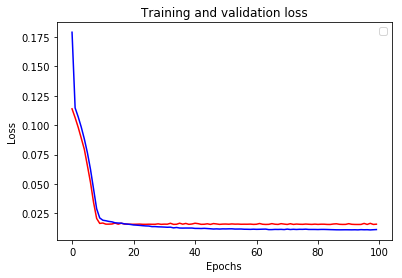

In [296]:
import matplotlib
#plt.plot(ae.history.history['val_loss'], 'r', ae.history.history['loss'], 'b')
plt.plot(model.history.history['val_loss'], 'r',model.history.history['loss'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [297]:
trainPredict = model.predict(trainX)
yhat = model.predict(testX, verbose=1)
print(yhat)

829/829 [==============================] - 0s 126us/step
[[0.23853543 0.23801176 0.23802894 0.23886366]
 [0.24283245 0.24232727 0.24235183 0.24316548]
 [0.24095683 0.240399   0.24049397 0.24118567]
 ...
 [0.9235444  0.9216424  0.9214989  0.92590475]
 [0.93821585 0.93620837 0.9360111  0.94061375]
 [0.95394576 0.9520103  0.95169705 0.95654774]]


In [298]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(yhat)
testY = scaler.inverse_transform(testY)

In [299]:
print(trainPredict)

[[50.688118 51.301636 50.107788 50.829876]
 [50.148396 50.75637  49.578854 50.284264]
 [49.280598 49.875847 48.724403 49.40824 ]
 ...
 [25.629955 25.954126 25.359266 25.679487]
 [25.504301 25.82684  25.233452 25.55531 ]
 [25.660336 25.985733 25.387157 25.713972]]


In [300]:
print(trainPredict.shape)

(3318, 4)


In [301]:
print(trainY)

[[50.077835 50.714893 49.6195   50.26181 ]
 [48.970596 49.588547 48.529    49.1481  ]
 [48.70758  49.233883 48.141827 48.621277]
 ...
 [25.564335 25.863918 25.303177 25.576916]
 [25.909664 26.200418 25.627802 25.900288]
 [25.489357 25.82033  25.262821 25.59126 ]]


In [302]:
print(trainY.shape)

(3318, 4)


In [303]:
print(testPredict)

[[25.335493 25.65613  25.06525  25.387653]
 [25.518175 25.84216  25.247108 25.570776]
 [25.438435 25.759037 25.168951 25.486498]
 ...
 [54.4578   55.125355 53.818027 54.63422 ]
 [55.08154  55.75325  54.428535 55.26037 ]
 [55.75028  56.43442  55.08843  55.93866 ]]


In [304]:
print(testPredict.shape)

(829, 4)


In [305]:
print(testY)

[[25.689804 25.992235 25.434107 25.720686]
 [25.232447 25.59277  25.040146 25.399208]
 [25.395525 25.665668 25.109612 25.35173 ]
 ...
 [55.800102 56.667484 55.293945 56.11977 ]
 [56.947098 57.588123 56.196785 56.784935]
 [57.70821  58.503117 57.120476 57.78838 ]]


In [306]:
print(testY.shape)

(829, 4)


In [307]:
original = (scaler.inverse_transform(train))
#print(scaler.inverse_transform(train))
print(original)

[[51.286648 51.855648 50.729305 51.301525]
 [50.794876 51.421833 50.318752 50.947674]
 [50.077835 50.714893 49.6195   50.26181 ]
 ...
 [25.564335 25.863918 25.303177 25.576916]
 [25.909664 26.200418 25.627802 25.900288]
 [25.489357 25.82033  25.262821 25.59126 ]]


In [308]:
Opentrain = original
print(Opentrain[:,:1])
print(Opentrain.shape)


[[51.286648]
 [50.794876]
 [50.077835]
 ...
 [25.564335]
 [25.909664]
 [25.489357]]
(3320, 4)


In [309]:
Hightrain = original
print(Hightrain[:,1:2])

[[51.855648]
 [51.421833]
 [50.714893]
 ...
 [25.863918]
 [26.200418]
 [25.82033 ]]


In [310]:
Lowtrain = original
print(Lowtrain[:,2:3])

[[50.729305]
 [50.318752]
 [49.6195  ]
 ...
 [25.303177]
 [25.627802]
 [25.262821]]


In [311]:
Closetrain = original
print(Closetrain[:,3:4])

[[51.301525]
 [50.947674]
 [50.26181 ]
 ...
 [25.576916]
 [25.900288]
 [25.59126 ]]


In [312]:
original_test = (scaler.inverse_transform(test))
print(scaler.inverse_transform(test))
print(original_test)
print(original_test.shape)

[[25.339935 25.620638 25.064596 25.33295 ]
 [25.471777 25.767136 25.219816 25.505585]
 [25.689804 25.992235 25.434107 25.720686]
 ...
 [55.800102 56.667484 55.293945 56.11977 ]
 [56.947098 57.588123 56.196785 56.784935]
 [57.70821  58.503117 57.120476 57.78838 ]]
[[25.339935 25.620638 25.064596 25.33295 ]
 [25.471777 25.767136 25.219816 25.505585]
 [25.689804 25.992235 25.434107 25.720686]
 ...
 [55.800102 56.667484 55.293945 56.11977 ]
 [56.947098 57.588123 56.196785 56.784935]
 [57.70821  58.503117 57.120476 57.78838 ]]
(831, 4)


In [313]:
Opentest = original_test
#print(Opentest[:,:1])
print(Opentest.shape)

(831, 4)


In [314]:
Hightest = original_test
#print(Hightest[:,1:2])

In [315]:
Lowtest = original_test
#print(Lowtest[:,2:3])

In [316]:
Closetest = original_test
#print(Closetest[:,3:4])

In [317]:
print(trainPredict)

[[50.688118 51.301636 50.107788 50.829876]
 [50.148396 50.75637  49.578854 50.284264]
 [49.280598 49.875847 48.724403 49.40824 ]
 ...
 [25.629955 25.954126 25.359266 25.679487]
 [25.504301 25.82684  25.233452 25.55531 ]
 [25.660336 25.985733 25.387157 25.713972]]


In [318]:
OpentrainPredict = trainPredict
print(OpentrainPredict[:,:1])

[[50.688118]
 [50.148396]
 [49.280598]
 ...
 [25.629955]
 [25.504301]
 [25.660336]]


In [319]:
HightrainPredict = trainPredict
print(HightrainPredict[:,1:2])

[[51.301636]
 [50.75637 ]
 [49.875847]
 ...
 [25.954126]
 [25.82684 ]
 [25.985733]]


In [320]:
LowtrainPredict = trainPredict
print(LowtrainPredict[:,2:3])

[[50.107788]
 [49.578854]
 [48.724403]
 ...
 [25.359266]
 [25.233452]
 [25.387157]]


In [321]:
ClosetrainPredict = trainPredict
print(ClosetrainPredict[:,3:4])

[[50.829876]
 [50.284264]
 [49.40824 ]
 ...
 [25.679487]
 [25.55531 ]
 [25.713972]]


In [322]:
OpentestPredict = testPredict
#print(OpentestPredict[:,:1])

In [323]:
HightestPredict = testPredict
#print(HightestPredict[:,1:2])

In [324]:
LowtestPredict = testPredict
#print(LowtestPredict[:,2:3])

In [325]:
ClosetestPredict = testPredict
#print(ClosetestPredict[:,3:4])

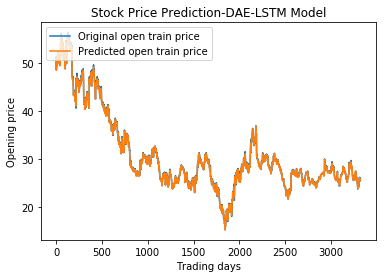

In [326]:
# # shift opentrain predictions for plotting
OpentrainPlot = np.empty_like(Opentrain[:,:1])
OpentrainPlot = Opentrain[:,:1]
# shift OpentrainPredict predictions for plotting
OpentrainPredictPlot = np.empty_like(OpentrainPredict[:,:1])
OpentrainPredictPlot = OpentrainPredict[:,:1]
# # plot baseline and predictions
plt.plot(OpentrainPlot, '', label='Original open train price' )
plt.plot(OpentrainPredictPlot, '', label='Predicted open train price' )
plt.ylabel('Opening price')
plt.xlabel("Trading days")
plt.legend(loc='upper left')
plt.title('Stock Price Prediction-DAE-LSTM Model')
plt.show()

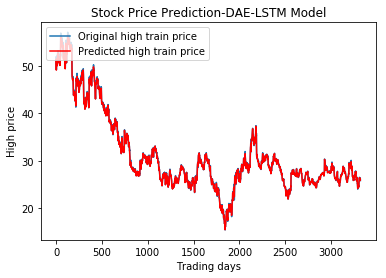

In [327]:
# # shift Hightrain predictions for plotting
HightrainPlot = np.empty_like(Hightrain[:,1:2])
HightrainPlot = Hightrain[:,1:2]
# shift HightrainPredict predictions for plotting
HightrainPredictPlot = np.empty_like(HightrainPredict[:,1:2])
HightrainPredictPlot = HightrainPredict[:,1:2]
# # plot baseline and predictions
plt.plot(HightrainPlot, '', label='Original high train price' )
plt.plot(HightrainPredictPlot, 'r', label='Predicted high train price' )
plt.ylabel('High price')
plt.xlabel("Trading days")
plt.legend(loc='upper left')
plt.title('Stock Price Prediction-DAE-LSTM Model')
plt.show()

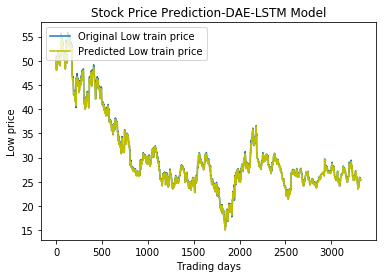

In [328]:
# # shift Lowtrain predictions for plotting
LowtrainPlot = np.empty_like(Lowtrain[:,2:3])
LowtrainPlot = Lowtrain[:,2:3]
# shift LowtrainPredict predictions for plotting
LowtrainPredictPlot = np.empty_like(LowtrainPredict[:,2:3])
LowtrainPredictPlot = LowtrainPredict[:,2:3]
# # plot baseline and predictions
plt.plot(LowtrainPlot, '', label='Original Low train price' )
plt.plot(LowtrainPredictPlot, 'y', label='Predicted Low train price' )
plt.ylabel('Low price')
plt.xlabel("Trading days")
plt.legend(loc='upper left')
plt.title('Stock Price Prediction-DAE-LSTM Model')
plt.show()

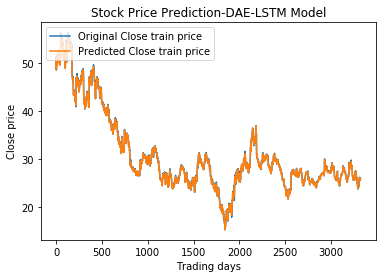

In [329]:
# # shift Closetrain predictions for plotting
ClosetrainPlot = np.empty_like(Closetrain[:,3:4])
ClosetrainPlot = Hightrain[:,3:4]
# shift ClosetrainPredict predictions for plotting
ClosetrainPredictPlot = np.empty_like(ClosetrainPredict[:,3:4])
ClosetrainPredictPlot = ClosetrainPredict[:,3:4]
# # plot baseline and predictions
plt.plot(ClosetrainPlot, '', label='Original Close train price' )
plt.plot(ClosetrainPredictPlot, '', label='Predicted Close train price' )
plt.ylabel('Close price')
plt.xlabel("Trading days")
plt.legend(loc='upper left')
plt.title('Stock Price Prediction-DAE-LSTM Model')
plt.show()

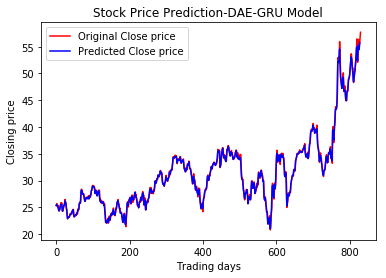

In [330]:

# shift OpentestPredict predictions for plotting
OpentestPlot = np.empty_like(Opentrain[:,:1])
OpentestPlot = Opentest[:,:1]
# shift OpentestPredict predictions for plotting
OpentestPredictPlot = np.empty_like(OpentestPredict[:,:1])
OpentestPredictPlot = OpentestPredict[:,:1]
# # plot baseline and predictions
plt.plot(OpentestPlot, 'r', label='Original Close price' )
plt.plot(OpentestPredictPlot, 'b', label='Predicted Close price' )
plt.ylabel('Closing price')
plt.xlabel("Trading days")
plt.legend(loc='upper left')
plt.title('Stock Price Prediction-DAE-GRU Model')
plt.show()

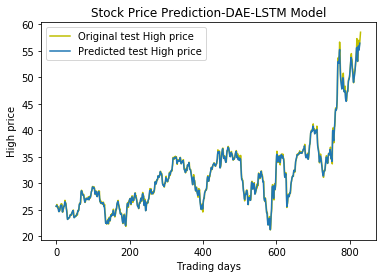

In [331]:
# shift Hightest predictions for plotting
HightestPlot = np.empty_like(Hightest[:,1:2])
HightestPlot = Hightest[:,1:2]
# shift HightestPredict predictions for plotting
HightestPredictPlot = np.empty_like(HightestPredict[:,1:2])
HightestPredictPlot = HightestPredict[:,1:2]
# # plot baseline and predictions
plt.plot(HightestPlot, 'y', label='Original test High price' )
plt.plot(HightestPredictPlot, '', label='Predicted test High price' )
plt.ylabel('High price')
plt.xlabel("Trading days")
plt.legend(loc='upper left')
plt.title('Stock Price Prediction-DAE-LSTM Model')
plt.show()

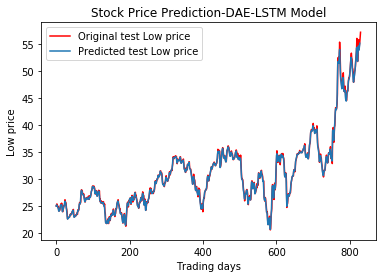

In [332]:
# shift Lowtest predictions for plotting
LowtestPlot = np.empty_like(Lowtest[:,2:3])
LowtestPlot = Lowtest[:,2:3]
# shift LowtrainPredict predictions for plotting
LowtestPredictPlot = np.empty_like(LowtestPredict[:,2:3])
LowtestPredictPlot = LowtestPredict[:,2:3]
# # plot baseline and predictions
plt.plot(LowtestPlot, 'r', label='Original test Low price' )
plt.plot(LowtestPredictPlot, '', label='Predicted test Low price' )
plt.ylabel('Low price')
plt.xlabel("Trading days")
plt.legend(loc='upper left')
plt.title('Stock Price Prediction-DAE-LSTM Model')
plt.show()

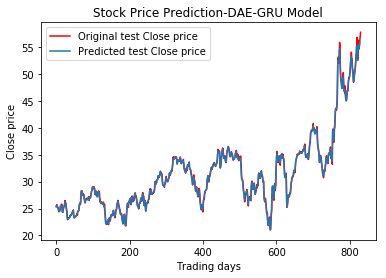

In [333]:
# shift Closetest predictions for plotting
ClosetestPlot = np.empty_like(Closetest[:,3:4])
ClosetestPlot = Closetest[:,3:4]
# shift ClosetrainPredict predictions for plotting
ClosetestPredictPlot = np.empty_like(ClosetestPredict[:,3:4])
ClosetestPredictPlot = ClosetestPredict[:,3:4]
# # plot baseline and predictions
plt.plot(ClosetestPlot, 'r', label='Original test Close price' )
plt.plot(ClosetestPredictPlot, '', label='Predicted test Close price' )
plt.ylabel('Close price')
plt.xlabel("Trading days")
plt.legend(loc='upper left')
plt.title('Stock Price Prediction-DAE-GRU Model')
plt.show()

In [334]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[:,:], trainPredict[:,:]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:,:], testPredict[:,:]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.52 RMSE
Test Score: 0.97 RMSE


In [335]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [336]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset), :] = testPredict

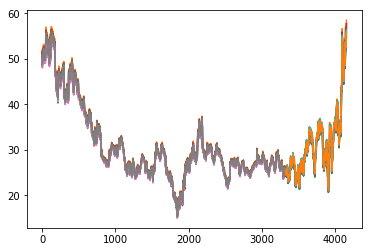

In [337]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [338]:
# PREDICT FUTURE VALUES
last_val = testPredict[-1,:]
print(last_val)
last_val_scaled = last_val/last_val
print(last_val_scaled)


[55.75028 56.43442 55.08843 55.93866]
[1. 1. 1. 1.]


In [339]:
yy = yhat[-2:,:]
yy=yy.reshape((-1,2,4))
print(np.shape(yy))
#print(yy)
nexty = model.predict(yy)
print(nexty)

(1, 2, 4)
[[0.9328017  0.93092346 0.93074405 0.9353167 ]]


In [340]:
actualnexty = scaler.inverse_transform(nexty)
print(actualnexty)

[[54.851364 55.52544  54.20696  55.034878]]


In [341]:
period = 4
yresult = []
yy = yhat[-2:,:]
#yy=yy.reshape((-1,2,4))
for i in range(period):
    yy=yy.reshape((-1,2,4))
    nexty = model.predict(yy)
    #print(nexty)
    actualnexty = scaler.inverse_transform(nexty)
    #print(actualnexty)
    yresult.append(actualnexty[0].tolist())
    yy = yy[0]
    #print(yy)
    yy=np.delete(yy,0,axis=0)
    #print(ary)
    yy=np.insert(yy,1,nexty[0],axis=0)
    #print(yy)
for y in yresult:
    print(y)

[54.85136413574219, 55.52544021606445, 54.20695877075195, 55.03487777709961]
[54.766231536865234, 55.428993225097656, 54.12242126464844, 54.939231872558594]
[54.28752136230469, 54.94943618774414, 53.65188980102539, 54.461551666259766]
[54.02434158325195, 54.68029022216797, 53.392669677734375, 54.19380187988281]


In [342]:
print(testY[:,3:])

[[25.720686]
 [25.399208]
 [25.35173 ]
 [25.121433]
 [25.10798 ]
 [24.504295]
 [24.44266 ]
 [24.438622]
 [24.573933]
 [24.980663]
 [25.469154]
 [25.619904]
 [25.319147]
 [25.835836]
 [25.455734]
 [24.43174 ]
 [24.262997]
 [24.754774]
 [24.931791]
 [25.392483]
 [25.42746 ]
 [25.443983]
 [26.489693]
 [26.077877]
 [26.101488]
 [25.856714]
 [25.098888]
 [24.662256]
 [24.076263]
 [23.010216]
 [22.949337]
 [23.11993 ]
 [23.27031 ]
 [23.275162]
 [23.279179]
 [23.303438]
 [23.71489 ]
 [23.750744]
 [23.678545]
 [23.86391 ]
 [23.813417]
 [24.167774]
 [24.28907 ]
 [24.40769 ]
 [24.552456]
 [24.7328  ]
 [23.819012]
 [23.328674]
 [23.289656]
 [23.359928]
 [23.52859 ]
 [23.537537]
 [23.551964]
 [23.685905]
 [23.7162  ]
 [24.098211]
 [23.759094]
 [24.497381]
 [24.523708]
 [24.563107]
 [24.611996]
 [25.329985]
 [26.022064]
 [25.694517]
 [25.822557]
 [26.016659]
 [27.876984]
 [28.325056]
 [28.329382]
 [28.171879]
 [27.768896]
 [27.616306]
 [27.359228]
 [27.670671]
 [27.215008]
 [26.755936]
 [26.39413 ]

In [343]:
print(testPredict[:,3:])

[[25.387653]
 [25.570776]
 [25.486498]
 [25.319195]
 [25.183283]
 [25.076372]
 [24.81294 ]
 [24.403957]
 [24.41726 ]
 [24.51645 ]
 [24.804522]
 [25.235964]
 [25.559725]
 [25.547966]
 [25.590002]
 [25.5933  ]
 [24.889067]
 [24.325155]
 [24.477453]
 [24.798538]
 [25.123217]
 [25.38606 ]
 [25.417507]
 [25.941479]
 [26.23427 ]
 [26.010494]
 [25.901808]
 [25.356049]
 [24.75361 ]
 [24.268091]
 [23.43017 ]
 [22.928942]
 [23.040407]
 [23.15161 ]
 [23.199865]
 [23.216322]
 [23.266594]
 [23.532242]
 [23.73053 ]
 [23.703657]
 [23.789543]
 [23.80346 ]
 [23.932934]
 [24.1845  ]
 [24.32303 ]
 [24.495462]
 [24.593351]
 [24.192625]
 [23.491875]
 [23.259941]
 [23.32024 ]
 [23.416012]
 [23.517323]
 [23.531805]
 [23.59411 ]
 [23.708447]
 [23.860262]
 [23.877977]
 [24.146984]
 [24.498875]
 [24.491184]
 [24.582829]
 [25.003721]
 [25.688107]
 [25.831604]
 [25.760693]
 [25.942225]
 [26.96909 ]
 [28.11377 ]
 [28.291489]
 [28.189577]
 [27.909338]
 [27.597496]
 [27.45288 ]
 [27.482725]
 [27.357733]
 [26.913488]

In [344]:
from sklearn.metrics import mean_absolute_error
Train_MAE = mean_absolute_error(trainY[:,:], trainPredict[:,:])
print(Train_MAE)
Test_MAE = mean_absolute_error(testY[:,:], testPredict[:,:])
print(Test_MAE)

0.3429305
0.67417765


In [345]:
from sklearn.metrics import r2_score
Train_R2 = r2_score(trainY[:,3:], trainPredict[:,3:])
print(Train_R2)
Test_R2 = r2_score(testY[:,3:], testPredict[:,3:])
print(Test_R2)

0.9964352190293422
0.9830598449379878


In [346]:
import numpy as np

def mean_absolute_percentage_error_train(trainY, trainPredict): 
    trainY, trainPredict = np.array(trainY[:,3:]), np.array(trainPredict[:,3:])
    return np.mean(np.abs((trainY[:,3:] - trainPredict[:,3:]) / trainY[:,3:])) * 100
print(mean_absolute_percentage_error_train(trainY[:,3:], trainPredict[:,3:]))

nan


/home/user/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [347]:
import numpy as np

def mean_absolute_percentage_error_test(testY, testPredict): 
    testY, testPredict = np.array(testY), np.array(testPredict)
    return np.mean(np.abs((testY - testPredict) / testY)) * 100
print(mean_absolute_percentage_error_test(testY, testPredict))

2.131004072725773
